#  Hybrid Classical-Quantum Transfer Learning for Cardiomegaly Detection in Chest X-Rays 

## load data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import random
import os
import copy
        
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset, Dataset
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset
from nngeometry.layercollection import LayerCollection
from nngeometry.metrics import FIM
from nngeometry.object import PMatKFAC, PMatDense
%matplotlib inline

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(123)
    
from watermark import watermark
%reload_ext watermark
%watermark 
%watermark --iversions

Last updated: 2023-02-26T10:01:34.679015+08:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.8.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 24
Architecture: 64bit

pandas     : 1.5.3
matplotlib : 3.6.3
seaborn    : 0.12.2
torch      : 1.13.1
numpy      : 1.23.5
torchvision: 0.14.1



In [2]:
import time
n_qubits = 4                     # Number of qubits.
q_depth = 6                      # Depth of the quantum circuit (number of variational layers).
max_layers = 15                  # Keep 15 even if not all are used.
q_delta = 0.01                   # Initial spread of random quantum weights.

step = 10e-4                     # Learning rate.
weight_decay = 10e-4             # Weight_decay for learning rate.
batch_size = 8                   # Number of samples for each training step.
init_epochs = 2                  # Number of init epochs.
train_epochs = 18                # Number of training epochs.
step_size= 2                     # Learning rate changing epochs.
gamma_lr_scheduler = 0.3         # Learning rate reduction applied every step_size epochs.  

start_time = time.time()         # Start of the computation timer

In [3]:
from tqdm import tqdm 
import time
start = time.time()
img_size = 256

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_size, img_size)), 
        transforms.CenterCrop((224,224)),
        #transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAutocontrast(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}


data_dir = 'chexpert-corrected/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                     data_transforms[x]) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Initialize dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True) for x in ['train', 'val']}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # We apply the inverse of the initial normalization operation.
    if transforms.Normalize in data_transforms['val'].transforms:
        norm = tranform_start[trans_list.index(transforms.Normalize)]
        mean = np.array(norm.mean)#np.array([0.485, 0.456, 0.406])
        std = np.array(norm.std)#np.array([0.229, 0.224, 0.225])
        img = std * input_tensor + mean  
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

own_elapsed = time.time() - start
print("Time elapsed: ", own_elapsed)

Time elapsed:  0.014530420303344727


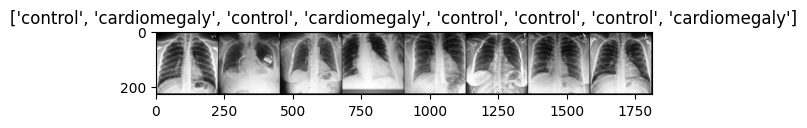

In [4]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
#resize image
import cv2
import PIL
from glob import glob

def read_img(img_path,tranform_):
    img = cv2.imread(img_path)
    transform = transforms.Compose(tranform_)
    img = transform(PIL.Image.fromarray(img))
    return img

print('Scans found:', len(image_datasets['train'].imgs)+ len(image_datasets['val'].imgs))

Scans found: 2436


### GradCam

In [6]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50,resnext50_32x4d,resnet18,densenet161,wide_resnet50_2, densenet121, densenet161
from PIL import Image

### pre-process dataset
generate image from address

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#device = 'cpu' #qiskit don't support gpu on windows

cuda:0


In [8]:
from tqdm import tqdm 
train_img = []
train_ids = []
train_y = []

img_size=256
tranform_ = [transforms.Resize((img_size, img_size)), 
             transforms.CenterCrop((224,224)),
             #transforms.RandomRotation(30),
             #transforms.RandomHorizontalFlip(p=0.5),
             #transforms.RandomAutocontrast(p=0.5),
             #transforms.ToTensor(),
             #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]

train_img = []
train_ids = []
train_y = []

for img_path in tqdm(image_datasets["train"].imgs):
    train_img.append(read_img(img_path[0],tranform_))
    train_ids.append(img_path[0].split("\\")[2])
    train_y.append(img_path[1])
    
#valid_img = []
#valid_ids = []
#valid_y = []
#
#for img_path in tqdm(image_datasets["val"].imgs):
#    valid_img.append(read_img(img_path[0],tranform_))
#    valid_ids.append(img_path[0].split("\\")[2])
#    valid_y.append(img_path[1])
    
test_img = []
test_ids = []
test_y = []
for img_path in tqdm(image_datasets["val"].imgs):
    test_img.append(read_img(img_path[0],tranform_))
    test_ids.append(img_path[0].split("\\")[2])
    test_y.append(img_path[1])

100%|███████████████████████████████████████████████████████████████████████████████| 730/730 [00:01<00:00, 451.47it/s]


In [9]:
#qamp_IMAGE_DIR = "qamp"

import time
start = time.time()

# * better way

tranform_ = [#transforms.Resize((img_size, img_size)), 
             #transforms.CenterCrop((224,224)),
             #transforms.RandomRotation(30),
             #transforms.RandomHorizontalFlip(p=0.5),
            #transforms.RandomVerticalFlip(p=0.5),
             #transforms.RandomAutocontrast(p=1.0),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
transform = transforms.Compose(tranform_)

train_imgg = []
for img in tqdm(train_img):
    img = transform(img)
    train_imgg.append(img)
##train_ds=torch.tensor(np.array(train_img), device=device).float()
train_y = torch.tensor(train_y, device=device).float()
train_ds = TensorDataset(torch.stack(train_imgg).to(device), train_y)
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True)
train_size = len(train_dataloader)

tranform_ = [#transforms.Resize((img_size, img_size)), 
             #transforms.CenterCrop((224,224)),
             #transforms.RandomRotation(30),
             #transforms.RandomHorizontalFlip(p=0.5),
             #transforms.RandomAutocontrast(p=1.0),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
transform = transforms.Compose(tranform_)

#valid_imgg=[]
#for img in tqdm(valid_img):
#    img = transform(img)
#    valid_imgg.append(img)
###valid_ds=torch.tensor(np.array(valid_img), device=device).float()
#valid_y = torch.tensor(valid_df['Cardiomegaly'].values, device=device).float()
#valid_ds = TensorDataset(torch.stack(valid_imgg).to(device), valid_y)
#valid_dataloader = torch.utils.data.DataLoader(valid_ds, batch_size=2, shuffle=True)
#valid_size = len(valid_dataloader)

test_img_ = []
for img in tqdm(test_img):
    img = transform(img)
    test_img_.append(img)
#test_ds=torch.tensor(np.array(test_img_), device=device).float()
test_y = torch.tensor(test_y, device=device).float()
test_ds = TensorDataset(torch.stack(test_img_).to(device), test_y)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False)#, sampler= sampler)


own_elapsed = time.time() - start
print("Time elapsed: ", own_elapsed)

100%|██████████████████████████████████████████████████████████████████████████████| 730/730 [00:00<00:00, 1062.43it/s]


Time elapsed:  4.346383333206177


## Neural Network

In [10]:
# install instruction - https://www.delftstack.com/howto/python/python-graphviz-executables-are-not-found/
#from torchviz import make_dot
#
#model = resnet18()
#batch = next(iter(train_dataloader))[0]
##x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)#8, 3, 224, 224
#yhat = model(batch) # Give dummy batch to forward().
#make_dot(yhat, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="png")

In [11]:
from math import pi
from scipy.special import logsumexp
import numpy as np


# This class is used to calculate the effective dimension of a model (classical or quantum)
# It implicitly computed the normalised Fisher information (which is called fhat) and then computes the eff dimension


class EffectiveDimension:
    def __init__(self, model, num_thetas, num_inputs):
        """
        Computes the effective dimension for a parameterised model.
        :param model: class instance
        :param num_thetas: int, number of parameter sets to include
        :param num_inputs: int, number of input samples to include
        """
        self.model = model
        self.d = model.d
        self.num_thetas = num_thetas
        self.num_inputs = num_inputs
        # Stack data together and combine parameter sets to make calcs more efficient
        rep_range = np.tile(np.array([num_inputs]), num_thetas)
        params = np.random.uniform(self.model.thetamin, self.model.thetamax, size=(self.num_thetas, model.d))
        self.params = np.repeat(params, repeats=rep_range, axis=0)
        x = np.random.normal(0, 1, size=(self.num_inputs, self.model.inputsize))
        self.x = np.tile(x, (self.num_thetas, 1))

    def get_fhat(self):
        """
        :return: ndarray, f_hat values of size (num_inputs, d, d)
        """
        grads = self.model.get_gradient(params=self.params, x=self.x)  # get gradients, dp_theta
        output = self.model.forward(params=self.params, x=self.x)  # get model output
        fishers = self.model.get_fisher(gradients=grads, model_output=output)
        fisher_trace = np.trace(np.average(fishers, axis=0))  # compute the trace with all fishers
        # average the fishers over the num_inputs to get the empirical fishers
        fisher = np.average(np.reshape(fishers, (self.num_thetas, self.num_inputs, self.d, self.d)), axis=1)
        f_hat = self.d * fisher / fisher_trace  # calculate f_hats for all the empirical fishers
        return f_hat, fisher_trace

    def eff_dim(self, f_hat, n):
        """
        Compute the effective dimension.
        :param f_hat: ndarray
        :param n: list, used to represent number of data samples available as per the effective dimension calc
        :return: list, effective dimension for each n
        """
        effective_dim = []
        for ns in n:
            Fhat = f_hat * ns / (2 * pi * np.log(ns))
            one_plus_F = np.eye(self.d) + Fhat
            det = np.linalg.slogdet(one_plus_F)[1]  # log det because of overflow
            r = det / 2  # divide by 2 because of sqrt
            effective_dim.append(2 * (logsumexp(r) - np.log(self.num_thetas)) / np.log(ns / (2 * pi * np.log(ns))))
        return effective_dim

### Quantum layer

In [12]:
import pennylane as qml
dev = qml.device('default.qubit', wires=n_qubits)

In [13]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates. 
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis. 
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    #CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT  
    for i in range(0, nqubits - 1, 2): #loop over even indices: i=0,2,...N-2  
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2): #loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [14]:
@qml.qnode(dev, interface='torch') 
def q_net(q_in, q_weights_flat):
        
        # Reshape weights
        q_weights = q_weights_flat.reshape(max_layers, n_qubits)
        
        # Start from state |+> , unbiased w.r.t. |0> and |1>
        H_layer(n_qubits)   
        
        # Embed features in the quantum node
        RY_layer(q_in)
        
       
        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k + 1])

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

### training function

In [15]:
import copy
from torchsummary import summary as quick_sum # this is buggy, but light
from torchinfo import summary # this is good, but take a lot of memory
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, auc, roc_curve, accuracy_score,confusion_matrix,classification_report
save_result = True
if save_result == True:
    # create folder and save the result
    time_str = time.strftime("%Y%m%d-%H%M%S")
    result_OUT = f"image_result/freezer_init_{time_str}"
    os.makedirs(result_OUT, exist_ok=True)

In [16]:
def get_variable_name(variable):
    globals_dict = globals()

    return [var_name for var_name in globals_dict if globals_dict[var_name] is variable]

In [17]:
def conf_matrix(y, y_pred):
    fig, ax =plt.subplots(figsize=(3.5,3.5))
    labels=['No','Yes']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title('Cardiomegaly?', fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test')
    ax.set_xlabel('Predicted')

In [18]:
def grad_camera(models, target_layers, picture_select, transform_start=None, transform_end=None,name=None):
    """ Train function
    Args:
        models: pytroch model
        target_layers :  target layer of the model
        picture_select (str): select picture from all the image
        transform_start : input picture display
        transform_end : output picture display
    Returns:
        pytorch model
    Raises:
        None
    """
    #target_layers = target_layers
    # need modify yourself
    if transform_start == None:
        tranform_start = [transforms.Resize((img_size, img_size)), 
                        transforms.CenterCrop((224,224)),
                        #transforms.RandomRotation(30),
                        #transforms.RandomHorizontalFlip(p=0.5),
                        #transforms.RandomAutocontrast(p=0.5),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ]
        #return tranform_start
    input_tensor = torch.stack([read_img(eval(f'image_datasets["train"].imgs{picture_select}[0]'), tranform_start)])#torch.stack(train_img)[:1,:,:,:]# Create an input tensor image for your model..
    print(input_tensor.numpy()[0].shape)
    y= models(input_tensor.to(device))
    # Note: input_tensor can be a batch tensor with several images!
    
    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAMPlusPlus(model=models, target_layers=target_layers)#, use_cuda=False)
    
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor.to(device))[0, :]#, targets=targets)[0, :]
    
    # In this example grayscale_cam has only one image in the batch:
    if transform_end == None:
        trans_list = list(map(type, tranform_start))
        input_tensor = input_tensor.numpy()[0]
        input_tensor = np.transpose(input_tensor, (1,2,0))
        if transforms.Normalize in trans_list:
            #img = np.transpose(input_tensor, (1,2,0))
            # We apply the inverse of the initial normalization operation.
            norm = tranform_start[trans_list.index(transforms.Normalize)]
            mean = np.array(norm.mean)#np.array([0.485, 0.456, 0.406])
            std = np.array(norm.std)#np.array([0.229, 0.224, 0.225])
            img = std * input_tensor + mean  
            input_tensor = np.clip(img, 0, 1)
    #img= read_img(eval(f'list(all_image_paths.values()){picture_select}'), transform_end)
    #img =np.float32(img) / 255
    visualization = show_cam_on_image(input_tensor, grayscale_cam, use_rgb=True)
    
    
    #_, y_prob = torch.max(y, 1)
    y_probb = nn.Sigmoid()(y)[0]
    df = image_datasets["train"].imgs
    plt.title(f'Cardiomegaly?\n true:{eval(f"df{picture_select}[1]")}\n pred[no/yes]:{np.round(y_probb.cpu().detach().numpy(),3)}', fontsize=20)
    #Image.fromarray(visualization, 'RGB')
    plt.imshow(visualization)
    if (save_result == True and name != None): plt.savefig(f"{result_OUT}/{name}_visual_img.png")
    return visualization

In [19]:
def train_model(model, criterion, optimizer,scheduler, num_epochs, loss_save=None, scheduler_set = ["outside_train"], sig_out = True,transform = True, save = True):
    """ Train function
    Args:
        model : pytroch model
        criterion :  Criterion
        optimizer : optimize
        scheduler : scheduler
        num_epochs (int): Number of epochs
        loss_save (bool): select model save condition, 
            it can be 'None' for best_loss_train, 'True' for best_acc or False for best_loss (default=None)
        scheduler_set (list): The set the scheduler place, 
            it can include ('inside_train', 'outside_train', 'inside_valid', 'outside_valid', outside_loss_valid)
        sig_out (bool): training sigmoid output
        transform (bool): transform each epoch
    Returns:
        pytorch model
    Raises:
        None
    """
    #qamp_IMAGE_DIR = "qamp"
    start = time.time()
    
    #layer_collection = LayerCollection.from_model(model)
    #d = layer_collection.numel()
    #print('d= ', d)
    name = get_variable_name(model)[0]
    print('name:',name)
    
    #train_ds=torch.tensor(np.array(train_img), device=device).float()
    
    
    #own_elapsed = time.time() - start
    #print("loader Time elapsed: ", own_elapsed)
    global train_ds
    global train_dataloader
    #global valid_ds
    #global valid_dataloader
    
    train_loss = []
    train_loss_list = []
    training_loss = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0   # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    opt_rate=[]
    for epoch in range(num_epochs):
        if transform:
            trans_start = time.time()
            tranform_ = [#transforms.Resize((img_size, img_size)), 
                 #transforms.CenterCrop((224,224)),
                 #transforms.RandomRotation(30),
                 #transforms.RandomHorizontalFlip(p=.5),
                 #transforms.RandomVerticalFlip(p=.5),
                 transforms.RandAugment(),
                 #transforms.RandomAdjustSharpness(sharpness_factor=2),
                 #transforms.RandomSolarize(threshold=192.0),
                 #transforms.RandomSolarize(threshold=192.0),
                 #transforms.RandomInvert(),
                 transforms.RandomAutocontrast(p=.5),
                 transforms.ToTensor(),
                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]
            transform = transforms.Compose(tranform_)
            
            train_imgg = []
            for img in train_img:
                img = transform(img)
                train_imgg.append(img)
            
            train_ds = TensorDataset(torch.stack(train_imgg).to(device), train_y)
            train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True)
            
            #valid_imgg=[]
            #for img in valid_img:
            #    img = transform(img)
            #    valid_imgg.append(img)
            #valid_ds = TensorDataset(torch.stack(valid_imgg).to(device), valid_y)
            #valid_dataloader = torch.utils.data.DataLoader(valid_ds, batch_size=2, shuffle=False)
            
            print("Transform Time elapsed: ", time.time() - trans_start)
        
        train_size = len(train_dataloader)
        #valid_size = len(valid_dataloader)
        
        running_loss = 0.0
        running_corrects = 0
        print(epoch+1,'Training started:')
        #for dataset_size_multiplier in range(5):
        for index, data in enumerate(tqdm(train_dataloader)):
            inputs, labels = data[0].to(device).type(torch.float), data[1].to(device).type(torch.long)
            #running_loss = 0.0
            # Set model to training mode
            model.train() 
            
            # Each epoch has a training and validation phase
            batch_size_ = len(inputs)
            optimizer.zero_grad()
            
            # Iterate over data.
            #n_batches = dataset_sizes[phase] // batch_size
            # Track/compute gradient and make an optimization step only when training
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                #nn.sigmoid(outputs)
                #print(outputs)
                if len(outputs.shape) == 1:
                    outputs = torch.stack([outputs])
                if sig_out == True:
                    outputs = nn.Sigmoid()(outputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)#torch.stack(label_list))
                loss.backward()
                optimizer.step()
                if "inside_train" in scheduler_set:
                    scheduler.step()
                
            
            # Print iteration results
            running_loss += loss.item() #*inputs.size(0)#* batch_size_
            train_loss.append(loss.item() )#*inputs.size(0))#*batch_size_)
            batch_corrects = torch.sum(preds == labels.data).item()
            running_corrects += batch_corrects
            if (index+1)%train_size == 0:
                #print(outputs)
                #print(preds)
                print('Train Epoch: {}/{} train loss {:.4f} Acc batch: {:.4f} learning_rate: {:.4f}'.format(epoch + 1, num_epochs, running_loss/train_size, running_corrects/train_ds.tensors[0].size(0),optimizer.state_dict()['param_groups'][0]['lr']))
                training_loss.append(running_loss/train_size)
        if running_corrects/len(train_ds) > best_acc_train:
            best_acc_train = running_loss
        if running_loss < best_loss_train:
            best_loss_train = running_corrects/len(train_ds)#round(new_train_df.shape[0]*split_size)
        if "outside_train" in scheduler_set:
            scheduler.step()
                
        train_loss_list.append(np.mean(train_loss))
        #opt_rate.append(optimizer.state_dict()['param_groups'][0]['lr'])
    if save_result: np.savetxt(f"{result_OUT}/{name}_training_loss.csv", training_loss)#save
    if save_result: np.savetxt(f"{result_OUT}/{name}_train_loss.csv", train_loss)#save
    if save_result: np.savetxt(f"{result_OUT}/{name}_train_loss_list.csv", train_loss_list)#save
            
    own_elapsed = time.time() - start
    print("Time elapsed: ", own_elapsed)
    
    # Print final results 
    #if loss_save != None:
    #    model.load_state_dict(best_model_wts)
    #print('Best test loss: {:.4f} | Best test accuracy: {:.4f}'.format(best_loss, best_acc))
    if len(train_loss_list) > 1:
        plt.rcParams["figure.figsize"] = (5.5, 4)
        plt.title("Training loss against Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Training loss")
        plt.plot(range(0,len(train_loss_list)), train_loss_list, color="blue")
        if save_result == True: plt.savefig(f"{result_OUT}/{name}_train_loss.png")#save pic
        plt.show()
    if save:
        running_loss = 0.0
        with torch.no_grad():
            model.eval()
            
            y_pred = []
            for index, data in enumerate(tqdm(test_dataloader)):
                model.eval()
                batch_inputs, batch_labels = data[0].to(device).type(torch.float), data[1].to(device).type(torch.long)
                with torch.set_grad_enabled(False):
                    outputs = model(batch_inputs)
                    y_pred.append(outputs[0])
                    #assert isinstance(outputs.item(), float)
                    #print(outputs, batch_labels)
                    #if len(outputs.shape) == 1:
                    #    outputs = torch.stack([outputs])
                    if sig_out == True:
                        outputs = nn.Sigmoid()(outputs)
                    #_, preds = torch.max(outputs, 1)
                    loss    = criterion(outputs, batch_labels)
                #print(f"Step {index} loss: {loss}")
                running_loss += loss.item()
            _, y_pred_prob = torch.max(torch.stack(y_pred), 1)
            y_pred_prob = y_pred_prob.cpu()
            if save_result == True: np.savetxt(f"{result_OUT}/{name}_test_loss.csv", y_pred_prob)#save
            #print(y_pred, y_pred_prob)
            print(classification_report(test_y.cpu().long(), torch.tensor(y_pred_prob.detach().numpy()),digits=4))
            conf_matrix(test_y.cpu().long(), y_pred_prob)
            if save_result == True: plt.savefig(f"{result_OUT}/{name}_conf_matrix.png")#save pic
            plt.figure(figsize = (5.5, 4))
            fpr, tpr, _ =roc_curve(test_y.cpu().long(), torch.tensor(y_pred_prob.detach().numpy()))
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
            plt.plot([0, 1], [0, 1],'r--')
            plt.title('ROC curve',fontsize=25)
            plt.ylabel('True Positive Rate',fontsize=18)
            plt.xlabel('False Positive Rate',fontsize=18)
            plt.legend(loc = 'lower right', fontsize=24, fancybox=True, shadow=True, frameon=True, handlelength=0)
            if save_result == True: plt.savefig(f"{result_OUT}/{name}_roc.png") #save pic
            plt.show()
    return model

## init_freezer

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
def n_count_parameters(model):
    return sum(p.numel() for p in model.parameters() if not(p.requires_grad))

In [21]:
def train_func(cnn_model,init_step, train_step,save_model=save_result):
    criterion = nn.CrossEntropyLoss()
    if init_step > 0:
        optimizer = torch.optim.Adam(cnn_model.parameters(), lr=step, weight_decay = weight_decay)
        #optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, cnn_model.parameters()), lr=10e-4, momentum=0.9)
        exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma_lr_scheduler)
        cnn_model = train_model(cnn_model.to(device), 
                                criterion, optimizer,exp_lr_scheduler, 
                                init_step,None,["outside_train"], False, True,False)
    
    for param in cnn_model.parameters():
        param.requires_grad = True
    
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=(step*0.3)*(np.floor(init_step/2)) if init_step > 0  else step, weight_decay = weight_decay)
    #optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, cnn_model.parameters()), lr=3e-4, momentum=0.9)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma_lr_scheduler)
    cnn_model = train_model(cnn_model.to(device), 
                            criterion, optimizer,exp_lr_scheduler, 
                            train_step,None,["outside_train"], False, True)#["outside_train"]
    
    cnn_model_visual = grad_camera(cnn_model, [cnn_model.features[-1]],[0] ,transform_start=None, transform_end=None,name=get_variable_name(cnn_model)[0])
    if save_model:
        torch.save(cnn_model.state_dict(),f"{result_OUT}/{get_variable_name(cnn_model)[0]}.pt")
    return cnn_model

In [22]:
def prob_loop(sample,models, target_layers, picture_select, transform_start=None, transform_end=None,name=None):
    # need modify yourself
    if transform_start == None:
        tranform_start = [transforms.Resize((img_size, img_size)), 
                        transforms.CenterCrop((224,224)),
                        #transforms.RandomRotation(30),
                        #transforms.RandomHorizontalFlip(p=0.5),
                        #transforms.RandomAutocontrast(p=0.5),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ]
    input_tensor = torch.stack([read_img(eval(f'image_datasets[sample].imgs{picture_select}[0]'), tranform_start)])#torch.stack(val_img)[:1,:,:,:]# Create an input tensor image for your model..
    y= models(input_tensor.to(device))
    
    y_probb = nn.Sigmoid()(y)[0]
    return y_probb


def make_df_y_probb(sample,model) :  
    df_y_probb = pd.DataFrame(columns=['image', 'p_yes', 'p_no'])
    df = image_datasets[sample].imgs
    for i in tqdm(range(len(df))):
        image_name = df[i][0][-10:]
        y_probb = prob_loop(sample, model, [model.features[-1]] \
            ,[i] ,transform_start=None, transform_end=None)
        y_probb = y_probb.cpu()
        p_yes = y_probb.detach().numpy()[0]
        p_no = y_probb.detach().numpy()[1]
        row = {'image' : image_name, 'p_yes': p_yes, 'p_no': p_no}
        new_df = pd.DataFrame([row])
        df_y_probb =  pd.concat([df_y_probb, new_df], axis = 0, ignore_index=True)
    return df_y_probb

def plot_ROC(name,y_true, y_score):

    # ROC Curve and AUROC
    plt.figure(0).clf()
    if np.sum(y_true) != 0.:        
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = round(roc_auc_score(y_true, y_score), 4)
        plt.plot(fpr,tpr,label=name + ", AUC =" + str(auc))
    if save_result == True: plt.savefig(f"{result_OUT}/{name}_roc.png") #save pic
    plt.legend()
    plt.show()

def make_csv(model, sample="val",result=True):
    df = make_df_y_probb(sample,model)
    if sample == "val":
        df_list = 361*[1] + 369*[0]
    elif sample == "train":
        df_list = 850*[1] + 856*[0]
    df = df.assign(label = df_list)

    pred_list = np.array(df.p_yes) / (np.array(df.p_yes) + np.array(df.p_no))
    df = df.assign(cmg_pred = pred_list)
    #elif sample == "train":
    #    pred_val_list =( np.array(df.p_yes) / (np.array(df.p_yes) + np.array(df.p_no)) + 0.5).astype('int32')
    #    df = df.assign(pred = pred_val_list)
    
    pred_list =( np.array(df.p_yes) / (np.array(df.p_yes) + np.array(df.p_no)) + 0.5).astype('int32')
    df = df.assign(pred = pred_list)
    
    df = df.rename(columns={"cmg_pred": "prob"})
    if sample == "val":
        df.sort_values(by = 'image')[0:16]
    elif sample == "train":
        df.sort_values(by = 'image')
    if save_result: df.to_csv(f'{result_OUT}/y_probbs_{get_variable_name(model)[0]}_{sample}.csv', index = False)
    
    if result:
        name = get_variable_name(model)[0]
        df_val = pd.read_csv(f'{result_OUT}/y_probbs_{name}_{sample}.csv') 
        prediction = np.array(df_val.prob) 
        name_ROC = f"Cardiomegaly - {name}_{sample}"
        plot_ROC(name_ROC, np.array(df_val.label), prediction)
        print(classification_report(np.array(df_val.label),  (prediction+ 0.5).astype('int32')))#prediction))
    return df

### densenet121


name: densenet121_model
Transform Time elapsed:  4.019105911254883
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:14<00:00, 14.60it/s]


Train Epoch: 1/2 train loss 0.6216 Acc batch: 0.6524 learning_rate: 0.0010
Transform Time elapsed:  4.084031105041504
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:13<00:00, 16.45it/s]


Train Epoch: 2/2 train loss 0.5713 Acc batch: 0.7046 learning_rate: 0.0010
Time elapsed:  35.830387592315674


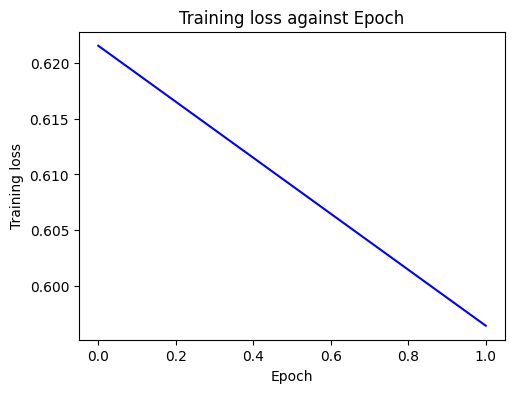

name: densenet121_model
Transform Time elapsed:  4.0499267578125
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:49<00:00,  4.32it/s]

Train Epoch: 1/18 train loss 0.4840 Acc batch: 0.7778 learning_rate: 0.0003


Transform Time elapsed:  4.137233018875122
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:51<00:00,  4.16it/s]

Train Epoch: 2/18 train loss 0.4002 Acc batch: 0.8306 learning_rate: 0.0003


Transform Time elapsed:  4.087080478668213
3 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:51<00:00,  4.17it/s]

Train Epoch: 3/18 train loss 0.3465 Acc batch: 0.8581 learning_rate: 0.0001


Transform Time elapsed:  4.052003860473633
4 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:51<00:00,  4.19it/s]

Train Epoch: 4/18 train loss 0.2927 Acc batch: 0.8875 learning_rate: 0.0001


Transform Time elapsed:  4.278925895690918
5 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:52<00:00,  4.11it/s]

Train Epoch: 5/18 train loss 0.2239 Acc batch: 0.9191 learning_rate: 0.0000


Transform Time elapsed:  4.062985181808472
6 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:51<00:00,  4.16it/s]

Train Epoch: 6/18 train loss 0.1942 Acc batch: 0.9302 learning_rate: 0.0000


Transform Time elapsed:  4.024247884750366
7 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:52<00:00,  4.04it/s]

Train Epoch: 7/18 train loss 0.1571 Acc batch: 0.9455 learning_rate: 0.0000


Transform Time elapsed:  4.137223482131958
8 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:51<00:00,  4.15it/s]

Train Epoch: 8/18 train loss 0.1515 Acc batch: 0.9496 learning_rate: 0.0000


Transform Time elapsed:  4.272245645523071
9 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:53<00:00,  4.00it/s]

Train Epoch: 9/18 train loss 0.1380 Acc batch: 0.9572 learning_rate: 0.0000


Transform Time elapsed:  4.292833089828491
10 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:52<00:00,  4.04it/s]

Train Epoch: 10/18 train loss 0.1287 Acc batch: 0.9578 learning_rate: 0.0000


Transform Time elapsed:  4.206945419311523
11 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:52<00:00,  4.08it/s]

Train Epoch: 11/18 train loss 0.1204 Acc batch: 0.9596 learning_rate: 0.0000


Transform Time elapsed:  4.071037769317627
12 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:53<00:00,  4.03it/s]

Train Epoch: 12/18 train loss 0.1496 Acc batch: 0.9560 learning_rate: 0.0000


Transform Time elapsed:  4.182279825210571
13 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:53<00:00,  4.00it/s]

Train Epoch: 13/18 train loss 0.1218 Acc batch: 0.9590 learning_rate: 0.0000


Transform Time elapsed:  4.199397563934326
14 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:53<00:00,  3.98it/s]

Train Epoch: 14/18 train loss 0.1461 Acc batch: 0.9560 learning_rate: 0.0000


Transform Time elapsed:  4.202875852584839
15 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:54<00:00,  3.93it/s]

Train Epoch: 15/18 train loss 0.1224 Acc batch: 0.9613 learning_rate: 0.0000


Transform Time elapsed:  4.394460439682007
16 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:55<00:00,  3.86it/s]

Train Epoch: 16/18 train loss 0.1141 Acc batch: 0.9666 learning_rate: 0.0000


Transform Time elapsed:  4.172089338302612
17 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:55<00:00,  3.88it/s]

Train Epoch: 17/18 train loss 0.1104 Acc batch: 0.9625 learning_rate: 0.0000


Transform Time elapsed:  4.243852138519287
18 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:53<00:00,  3.97it/s]

Train Epoch: 18/18 train loss 0.1170 Acc batch: 0.9666 learning_rate: 0.0000
Time elapsed:  1024.8491034507751


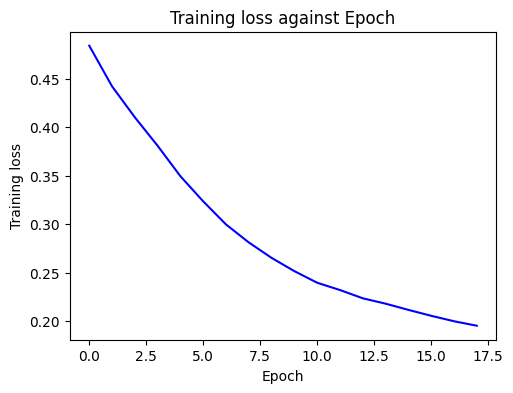

100%|████████████████████████████████████████████████████████████████████████████████| 730/730 [00:52<00:00, 13.95it/s]


              precision    recall  f1-score   support

           0     0.8680    0.8560    0.8619       361
           1     0.8610    0.8726    0.8668       369

    accuracy                         0.8644       730
   macro avg     0.8645    0.8643    0.8643       730
weighted avg     0.8644    0.8644    0.8644       730



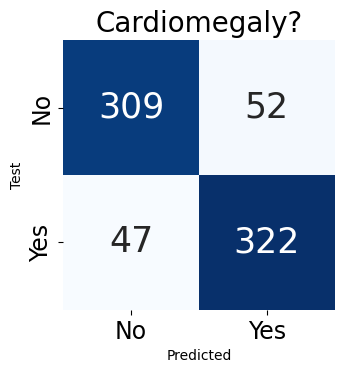

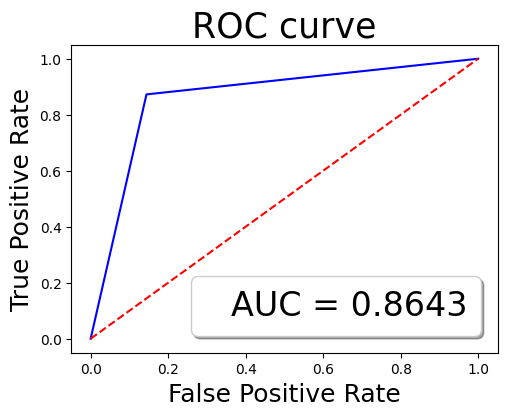

(3, 224, 224)


100%|██████████████████████████████████████████████████████████████████████████████| 1706/1706 [02:01<00:00, 14.01it/s]


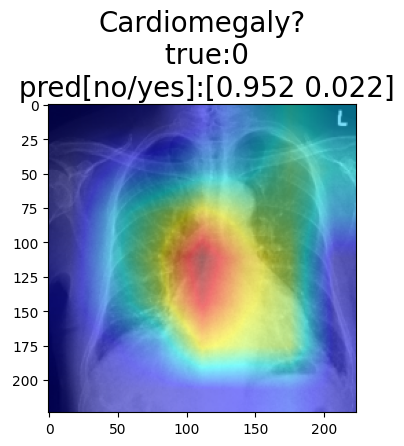

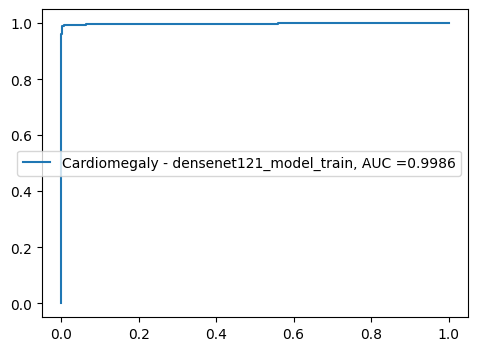

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       856
           1       1.00      0.99      0.99       850

    accuracy                           0.99      1706
   macro avg       0.99      0.99      0.99      1706
weighted avg       0.99      0.99      0.99      1706



100%|████████████████████████████████████████████████████████████████████████████████| 730/730 [00:51<00:00, 14.27it/s]


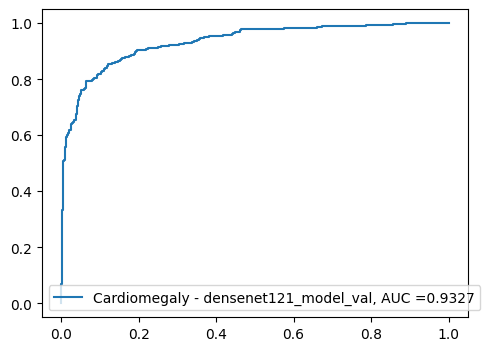

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       369
           1       0.87      0.86      0.86       361

    accuracy                           0.86       730
   macro avg       0.86      0.86      0.86       730
weighted avg       0.86      0.86      0.86       730



In [23]:
densenet121_model = torchvision.models.densenet121(weights= 'DEFAULT')
for param in densenet121_model.parameters():
    param.requires_grad = False
densenet121_model.classifier = nn.Sequential(nn.Linear(densenet121_model.classifier.in_features, 512), torch.nn.ReLU(), nn.Linear(512, 2))
densenet121_model = train_func(densenet121_model, init_epochs, train_epochs)

for i in ['train','val']:
    exec(f"densenet121_model_{i}=make_csv(densenet121_model,'{i}')")

### AlexNet hybird

name: alexnet_model
Transform Time elapsed:  4.3847291469573975
1 Training started:


100%|███████████████████████████████████████████████████████████████████████████████| 214/214 [00:01<00:00, 183.03it/s]


Train Epoch: 1/2 train loss 0.6962 Acc batch: 0.6659 learning_rate: 0.0010
Transform Time elapsed:  4.853071212768555
2 Training started:


100%|███████████████████████████████████████████████████████████████████████████████| 214/214 [00:01<00:00, 183.88it/s]


Train Epoch: 2/2 train loss 0.6600 Acc batch: 0.6788 learning_rate: 0.0010
Time elapsed:  11.582376956939697


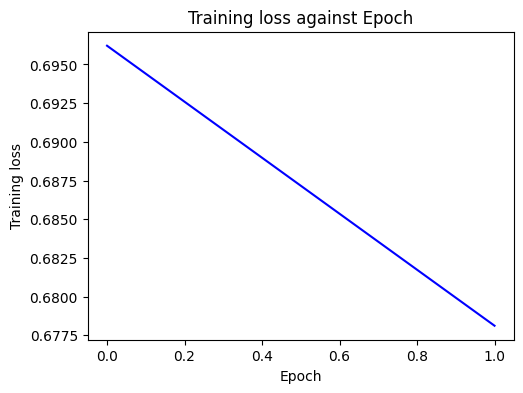

name: alexnet_model
Transform Time elapsed:  5.046317100524902
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 37.62it/s]


Train Epoch: 1/18 train loss 0.7277 Acc batch: 0.5744 learning_rate: 0.0003
Transform Time elapsed:  4.670663356781006
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.53it/s]


Train Epoch: 2/18 train loss 0.6772 Acc batch: 0.5551 learning_rate: 0.0003
Transform Time elapsed:  5.11537766456604
3 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.66it/s]


Train Epoch: 3/18 train loss 0.6688 Acc batch: 0.6149 learning_rate: 0.0001
Transform Time elapsed:  4.928955793380737
4 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.95it/s]


Train Epoch: 4/18 train loss 0.6549 Acc batch: 0.6301 learning_rate: 0.0001
Transform Time elapsed:  4.5743443965911865
5 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.71it/s]


Train Epoch: 5/18 train loss 0.6191 Acc batch: 0.6653 learning_rate: 0.0000
Transform Time elapsed:  4.963438034057617
6 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.96it/s]


Train Epoch: 6/18 train loss 0.5854 Acc batch: 0.6911 learning_rate: 0.0000
Transform Time elapsed:  4.265900373458862
7 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 35.94it/s]


Train Epoch: 7/18 train loss 0.5476 Acc batch: 0.7415 learning_rate: 0.0000
Transform Time elapsed:  4.421917915344238
8 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.04it/s]


Train Epoch: 8/18 train loss 0.5379 Acc batch: 0.7268 learning_rate: 0.0000
Transform Time elapsed:  4.327845573425293
9 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:06<00:00, 35.31it/s]


Train Epoch: 9/18 train loss 0.5038 Acc batch: 0.7649 learning_rate: 0.0000
Transform Time elapsed:  4.7360358238220215
10 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:06<00:00, 35.44it/s]


Train Epoch: 10/18 train loss 0.5139 Acc batch: 0.7603 learning_rate: 0.0000
Transform Time elapsed:  4.756479501724243
11 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.33it/s]


Train Epoch: 11/18 train loss 0.4910 Acc batch: 0.7755 learning_rate: 0.0000
Transform Time elapsed:  4.6097869873046875
12 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.40it/s]


Train Epoch: 12/18 train loss 0.4825 Acc batch: 0.7755 learning_rate: 0.0000
Transform Time elapsed:  4.629861116409302
13 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.24it/s]


Train Epoch: 13/18 train loss 0.5052 Acc batch: 0.7638 learning_rate: 0.0000
Transform Time elapsed:  4.893484115600586
14 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.21it/s]


Train Epoch: 14/18 train loss 0.4872 Acc batch: 0.7749 learning_rate: 0.0000
Transform Time elapsed:  4.88142728805542
15 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.58it/s]


Train Epoch: 15/18 train loss 0.4940 Acc batch: 0.7673 learning_rate: 0.0000
Transform Time elapsed:  4.653003692626953
16 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.32it/s]


Train Epoch: 16/18 train loss 0.4980 Acc batch: 0.7720 learning_rate: 0.0000
Transform Time elapsed:  4.557447195053101
17 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.57it/s]


Train Epoch: 17/18 train loss 0.4879 Acc batch: 0.7732 learning_rate: 0.0000
Transform Time elapsed:  4.32698392868042
18 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [00:05<00:00, 36.55it/s]


Train Epoch: 18/18 train loss 0.4928 Acc batch: 0.7761 learning_rate: 0.0000
Time elapsed:  190.37937760353088


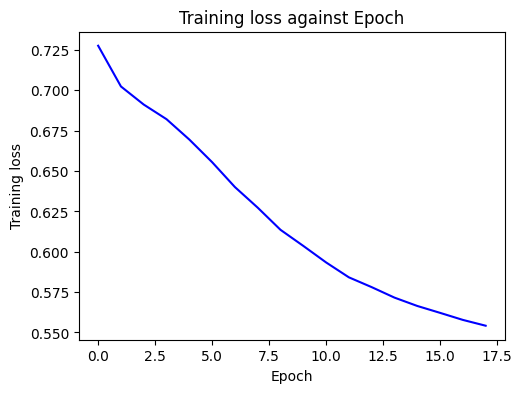

100%|███████████████████████████████████████████████████████████████████████████████| 730/730 [00:02<00:00, 247.09it/s]


              precision    recall  f1-score   support

           0     0.7849    0.7784    0.7816       361
           1     0.7849    0.7913    0.7881       369

    accuracy                         0.7849       730
   macro avg     0.7849    0.7849    0.7849       730
weighted avg     0.7849    0.7849    0.7849       730



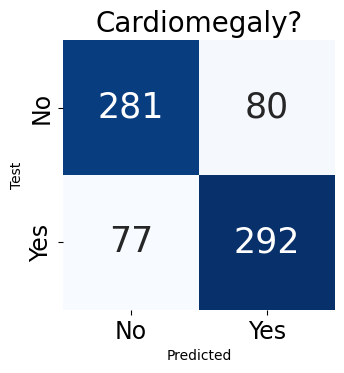

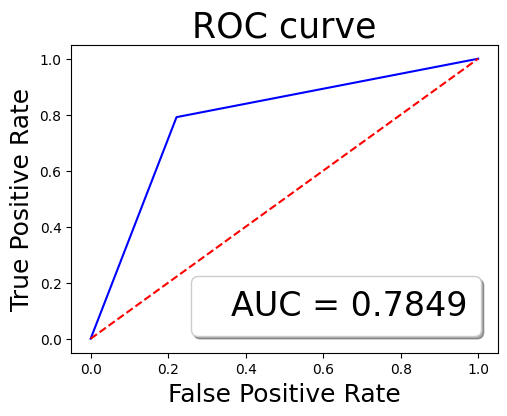

(3, 224, 224)


100%|█████████████████████████████████████████████████████████████████████████████| 1706/1706 [00:13<00:00, 129.67it/s]


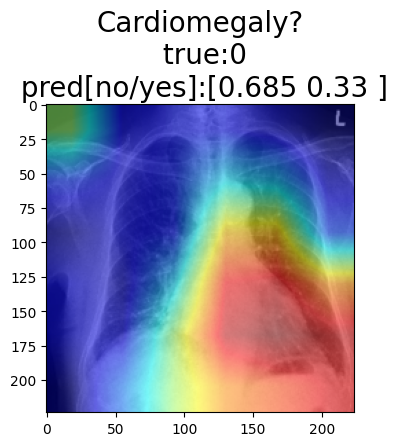

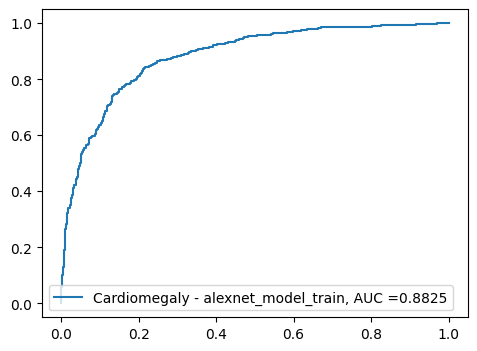

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       856
           1       0.80      0.80      0.80       850

    accuracy                           0.80      1706
   macro avg       0.80      0.80      0.80      1706
weighted avg       0.80      0.80      0.80      1706



100%|███████████████████████████████████████████████████████████████████████████████| 730/730 [00:05<00:00, 127.65it/s]


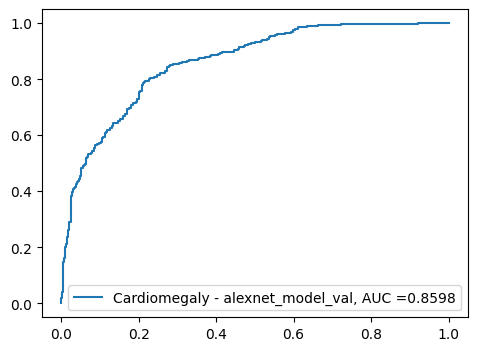

              precision    recall  f1-score   support

           0       0.78      0.79      0.79       369
           1       0.78      0.78      0.78       361

    accuracy                           0.78       730
   macro avg       0.78      0.78      0.78       730
weighted avg       0.78      0.78      0.78       730



In [24]:
alexnet_model = torchvision.models.alexnet(weights='DEFAULT')
for param in alexnet_model.parameters():
    param.requires_grad = False
alexnet_model.classifier.append(torch.nn.ReLU())
alexnet_model.classifier.append(nn.Linear(1000, 2))
#alexnet_model.classifier = nn.Sequential(nn.Linear(cnn_model.classifier[1].in_features, 512), torch.nn.ReLU(), nn.Linear(512, 2))
alexnet_model = train_func(alexnet_model, init_epochs, train_epochs)
for i in ['train','val']:
    exec(f"alexnet_model_{i}=make_csv(alexnet_model,'{i}')")

### Densenet 121 Pennylane hybird

name: PL_qnn_model
Transform Time elapsed:  4.208248138427734
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [02:29<00:00,  1.43it/s]

Train Epoch: 1/2 train loss 0.6539 Acc batch: 0.6284 learning_rate: 0.0010


Transform Time elapsed:  4.146907806396484
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [02:32<00:00,  1.40it/s]

Train Epoch: 2/2 train loss 0.6006 Acc batch: 0.7005 learning_rate: 0.0010
Time elapsed:  310.81911540031433


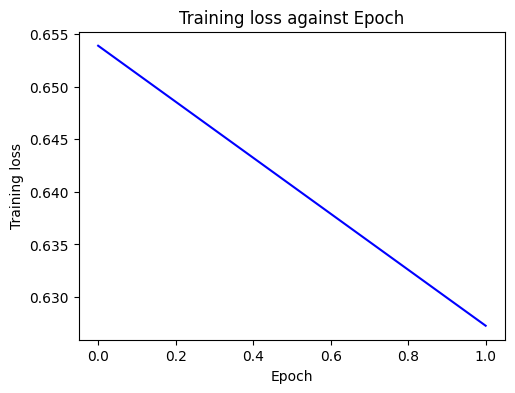

name: PL_qnn_model
Transform Time elapsed:  4.172680377960205
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:13<00:00,  1.10it/s]

Train Epoch: 1/18 train loss 0.6063 Acc batch: 0.6975 learning_rate: 0.0003


Transform Time elapsed:  4.747308015823364
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:15<00:00,  1.10it/s]

Train Epoch: 2/18 train loss 0.5659 Acc batch: 0.7374 learning_rate: 0.0003


Transform Time elapsed:  4.265328407287598
3 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:11<00:00,  1.12it/s]

Train Epoch: 3/18 train loss 0.5004 Acc batch: 0.7902 learning_rate: 0.0001


Transform Time elapsed:  4.407380104064941
4 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:09<00:00,  1.13it/s]

Train Epoch: 4/18 train loss 0.4577 Acc batch: 0.8259 learning_rate: 0.0001


Transform Time elapsed:  4.231111288070679
5 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:05<00:00,  1.15it/s]

Train Epoch: 5/18 train loss 0.4292 Acc batch: 0.8523 learning_rate: 0.0000


Transform Time elapsed:  4.140270948410034
6 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:32<00:00,  1.01it/s]

Train Epoch: 6/18 train loss 0.4161 Acc batch: 0.8664 learning_rate: 0.0000


Transform Time elapsed:  4.344225883483887
7 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:19<00:00,  1.07it/s]

Train Epoch: 7/18 train loss 0.4031 Acc batch: 0.8716 learning_rate: 0.0000


Transform Time elapsed:  4.140764236450195
8 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:07<00:00,  1.14it/s]

Train Epoch: 8/18 train loss 0.4039 Acc batch: 0.8710 learning_rate: 0.0000


Transform Time elapsed:  4.870235919952393
9 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:07<00:00,  1.14it/s]

Train Epoch: 9/18 train loss 0.4074 Acc batch: 0.8623 learning_rate: 0.0000


Transform Time elapsed:  4.235482931137085
10 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:06<00:00,  1.15it/s]

Train Epoch: 10/18 train loss 0.3832 Acc batch: 0.8892 learning_rate: 0.0000


Transform Time elapsed:  4.137414455413818
11 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:07<00:00,  1.14it/s]

Train Epoch: 11/18 train loss 0.3895 Acc batch: 0.8804 learning_rate: 0.0000


Transform Time elapsed:  4.1290202140808105
12 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:06<00:00,  1.15it/s]

Train Epoch: 12/18 train loss 0.3897 Acc batch: 0.8804 learning_rate: 0.0000


Transform Time elapsed:  4.1390697956085205
13 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:06<00:00,  1.15it/s]

Train Epoch: 13/18 train loss 0.3892 Acc batch: 0.8792 learning_rate: 0.0000


Transform Time elapsed:  4.0845630168914795
14 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:06<00:00,  1.15it/s]

Train Epoch: 14/18 train loss 0.3954 Acc batch: 0.8757 learning_rate: 0.0000


Transform Time elapsed:  4.080488204956055
15 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:06<00:00,  1.15it/s]

Train Epoch: 15/18 train loss 0.3896 Acc batch: 0.8804 learning_rate: 0.0000


Transform Time elapsed:  4.117847681045532
16 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:06<00:00,  1.15it/s]

Train Epoch: 16/18 train loss 0.3813 Acc batch: 0.8863 learning_rate: 0.0000


Transform Time elapsed:  4.24861478805542
17 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:05<00:00,  1.15it/s]

Train Epoch: 17/18 train loss 0.3827 Acc batch: 0.8863 learning_rate: 0.0000


Transform Time elapsed:  4.065093517303467
18 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [03:07<00:00,  1.14it/s]

Train Epoch: 18/18 train loss 0.3885 Acc batch: 0.8810 learning_rate: 0.0000
Time elapsed:  3496.6158657073975


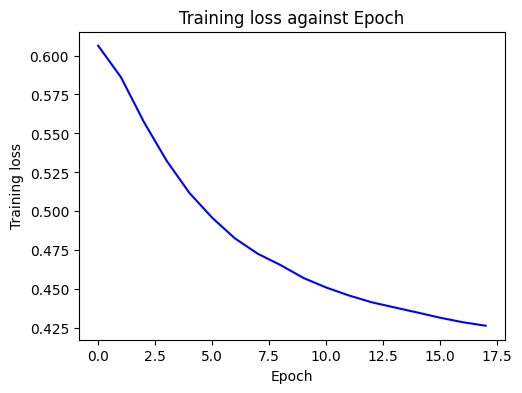

100%|████████████████████████████████████████████████████████████████████████████████| 730/730 [01:31<00:00,  7.94it/s]


              precision    recall  f1-score   support

           0     0.8403    0.8892    0.8641       361
           1     0.8851    0.8347    0.8591       369

    accuracy                         0.8616       730
   macro avg     0.8627    0.8619    0.8616       730
weighted avg     0.8629    0.8616    0.8616       730



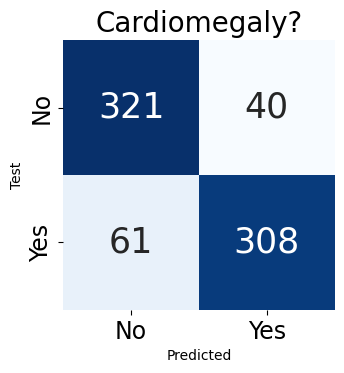

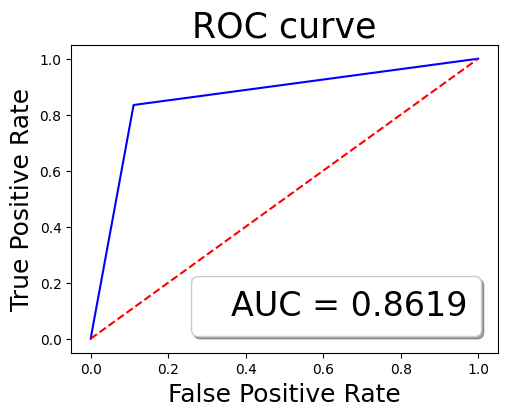

(3, 224, 224)


100%|██████████████████████████████████████████████████████████████████████████████| 1706/1706 [03:38<00:00,  7.82it/s]


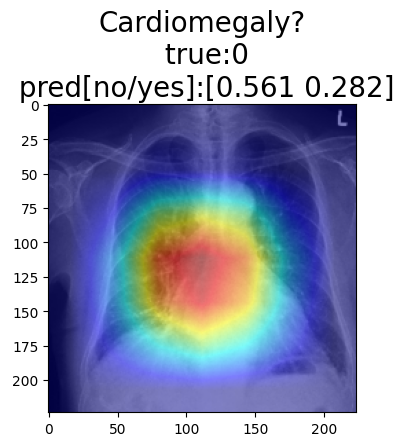

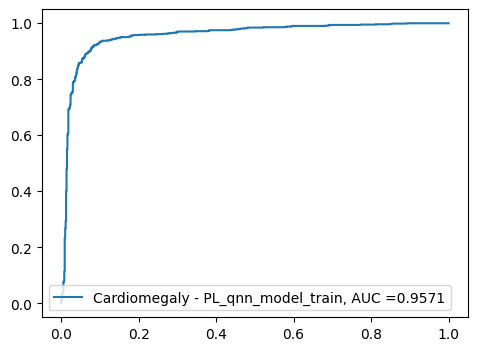

              precision    recall  f1-score   support

           0       0.94      0.86      0.90       856
           1       0.87      0.94      0.91       850

    accuracy                           0.90      1706
   macro avg       0.91      0.90      0.90      1706
weighted avg       0.91      0.90      0.90      1706



100%|████████████████████████████████████████████████████████████████████████████████| 730/730 [01:32<00:00,  7.86it/s]


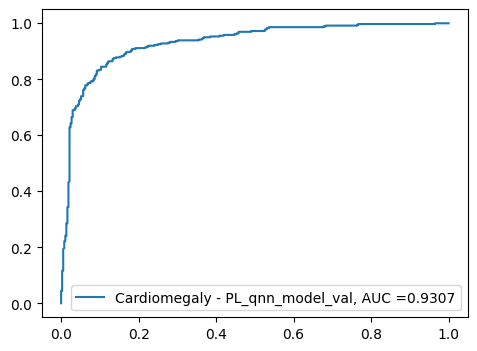

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       369
           1       0.84      0.89      0.86       361

    accuracy                           0.86       730
   macro avg       0.86      0.86      0.86       730
weighted avg       0.86      0.86      0.86       730



In [25]:
class Quantumnet(nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.pre_net = nn.Linear(input_size, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        pre_out = self.pre_net(input_features) 
        q_in = torch.tanh(pre_out) * np.pi / 2.0   
        
        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = q_net(elem,self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))
        return self.post_net(q_out)

PL_qnn_model = torchvision.models.densenet121(weights= 'DEFAULT')
for param in PL_qnn_model.parameters():
    param.requires_grad = False
PL_qnn_model.classifier = Quantumnet(PL_qnn_model.classifier.in_features)
 #quick_sum(qnn_model,torch.stack(train_imgg).shape[1:],device=device)
PL_qnn_model= train_func(PL_qnn_model, init_epochs, train_epochs)

'''
# Downgrade cuda driver if you meet this error:
nvrtc: error: failed to open nvrtc-builtins64_117.dll.
  Make sure that nvrtc-builtins64_117.dll is installed correctly.
'''

for i in ['train','val']:
    exec(f"PL_qnn_model_{i}=make_csv(PL_qnn_model,'{i}')")

### prepare for simulator

In [26]:
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap,EfficientSU2, PauliFeatureMap,TwoLocal,ZFeatureMap,NLocal
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN, OpflowQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow.gradients import Gradient, Hessian #, NaturalGradient, QFI, 
from qiskit import QuantumCircuit, transpile, Aer ,  execute, BasicAer, assemble, IBMQ
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.neural_networks import EffectiveDimension, LocalEffectiveDimension
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
input_dim = n_qubits

In [27]:
def simulator_train(feature_map, ansatz,effective=None,hardware='CPU',num_layer=0,output_dim=4):
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qc = feature_map.compose(ansatz)
    simulator = Aer.get_backend('aer_simulator_statevector')
    # detail_explaination: https://qiskit.org/documentation/stubs/qiskit_aer.AerSimulator.html
    simulator.set_options(
        device=hardware,
        max_parallel_threads = 0, #max_parallel_shots
        max_parallel_experiments = 0, #equal 0 means maximum number of experiments that may be executed in parallel equals max_parallel_threads value.
        max_parallel_shots = 1, #equal 1 means disable parallel shot execution.
        statevector_parallel_threshold = input_dim,
        blocking_enable = True,
    )
    qnn = CircuitQNN(
                circuit=qc,
                input_params=feature_map.parameters,
                weight_params=ansatz.parameters,
                interpret=lambda x: x % output_dim,
                output_shape=output_dim,
                gradient= None,#Gradient(grad_method='lin_comb'), #param_shift
                quantum_instance= QuantumInstance(simulator, shots=10),
                input_gradients=True,
            )
    initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn.num_weights) - 1)
    model1 = TorchConnector(qnn, initial_weights=initial_weights)
    print(model1(torch.tensor(0.1 * (2 * algorithm_globals.random.random(input_dim) - 1))))
    if effective:
        # we can set the total number of input samples and weight samples for random selection
    
        global_ed = EffectiveDimension(
            qnn=qnn, weight_samples=10, input_samples=10
        )
        
        # finally, we will define ranges to test different numbers of data, n
        n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]
        #n = [1000, 2000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]
        global_eff_dim_0 = global_ed.get_effective_dimension(dataset_size=n[0])
        
        d = qnn.num_weights
        
        print("Data size: {}, global effective dimension: {:.4f}".format(n[0], global_eff_dim_0))
        print(
            "Number of weights: {}, normalized effective dimension: {:.4f}".format(d, global_eff_dim_0 / d)
        )
        
        global_eff_dim_1 = global_ed.get_effective_dimension(dataset_size=n)
        
        print("Effective dimension: {}".format(global_eff_dim_1))
        print("Number of weights: {}".format(d))
        
        # plot the normalized effective dimension for the model
        plt.plot(n, np.array(global_eff_dim_1) / d)
        plt.xlabel("Number of data")
        plt.ylabel("Normalized GLOBAL effective dimension")
        if save_result : plt.savefig(f"{result_OUT}/{effective}_effective.png")
        plt.show()
    class Quantumnet(nn.Module):
        def __init__(self,input_size):
            super().__init__()
            self.pre_net = nn.Linear(input_size, input_dim)
            #self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
            self.qnn = TorchConnector(qnn)#,initial_weights)
            for i in range(num_layer):
                exec(f"self.qnn{i}= TorchConnector(qnn{i})")
            self.post_net = nn.Linear(output_dim, 2)

        def forward(self, input_features):
            pre_out = self.pre_net(input_features)
            q_in = torch.tanh(pre_out) * np.pi / 2.0   
            q_out = self.qnn(q_in).float()
            #print(q_out)
            for i in range(num_layer):
                q_out = torch.tanh(q_out) * np.pi / 2.0  
                q_out = eval(f"self.qnn{i}().float()")
            
            # Apply the quantum circuit to each element of the batch and append to q_out
            #q_out = torch.Tensor(0, n_qubits)
            #q_out = q_out.to(device)
            return self.post_net(q_out)
    return Quantumnet

### Densenet Qiskit hybird easy qnn
same circuit from pennylane, might have better result than [Automated Detection of Alzheimer’s via Hybrid Classical Quantum Neural Networks](https://www.mdpi.com/2079-9292/11/5/721/pdf-vor)

In [28]:
parm = ParameterVector('phi', input_dim)
param = ParameterVector('deta',q_depth*input_dim)
feature_map = QuantumCircuit(input_dim)
feature_map.h(range(input_dim))
for i,j in enumerate(parm):
    feature_map.ry(j,i)
#for k in range(feature_map.num_qubits-1):
#    feature_map.cnot(k,k+1)
feature_map.barrier()

feature_map.draw()

ansatz = QuantumCircuit(input_dim)
k=0
for i in range(q_depth):
    for j in range(ansatz.num_qubits-1):
        ansatz.cnot(j,j+1)
    ansatz.barrier()
    
    for j in range(ansatz.num_qubits):
        ansatz.ry(param[k],j)
        k+=1
    ansatz.barrier()
print(ansatz.num_parameters)
feature_map.compose(ansatz).draw()

#feature_map = ZFeatureMap(input_dim,reps=1)
#ansatz = RealAmplitudes(input_dim, reps=q_depth,entanglement='linear',skip_final_rotation_layer=True,insert_barriers=True)
#feature_map.decompose(reps=1).draw()

24


┌───┐┌────────────┐ ░                 ░ ┌─────────────┐ ░                »
q_0: ┤ H ├┤ Ry(phi[0]) ├─░───■─────────────░─┤ Ry(deta[0]) ├─░───■────────────»
     ├───┤├────────────┤ ░ ┌─┴─┐           ░ ├─────────────┤ ░ ┌─┴─┐          »
q_1: ┤ H ├┤ Ry(phi[1]) ├─░─┤ X ├──■────────░─┤ Ry(deta[1]) ├─░─┤ X ├──■───────»
     ├───┤├────────────┤ ░ └───┘┌─┴─┐      ░ ├─────────────┤ ░ └───┘┌─┴─┐     »
q_2: ┤ H ├┤ Ry(phi[2]) ├─░──────┤ X ├──■───░─┤ Ry(deta[2]) ├─░──────┤ X ├──■──»
     ├───┤├────────────┤ ░      └───┘┌─┴─┐ ░ ├─────────────┤ ░      └───┘┌─┴─┐»
q_3: ┤ H ├┤ Ry(phi[3]) ├─░───────────┤ X ├─░─┤ Ry(deta[3]) ├─░───────────┤ X ├»
     └───┘└────────────┘ ░           └───┘ ░ └─────────────┘ ░           └───┘»
«      ░ ┌─────────────┐ ░                 ░ ┌─────────────┐  ░                »
«q_0: ─░─┤ Ry(deta[4]) ├─░───■─────────────░─┤ Ry(deta[8]) ├──░───■────────────»
«      ░ ├─────────────┤ ░ ┌─┴─┐           ░ ├─────────────┤  ░ ┌─┴─┐          »
«q_1: ─░─┤ Ry(deta[5]) ├─░─┤ X ├──■────────░─┤ Ry(deta[9]) ├──░─┤ X ├──■───────»
«      ░ ├─────────────┤ ░ └───┘┌─┴─┐      ░ ├─────────────┴┐ ░ └───┘┌─┴─┐     »
«q_2: ─░─┤ Ry(deta[6]) ├─░──────┤ X ├──■───░─┤ Ry(deta[10]) ├─░──────┤ X ├──■──»
«      ░ ├─────────────┤ ░      └───┘┌─┴─┐ ░ ├──────────────┤ ░      └───┘┌─┴─┐»
«q_3: ─░─┤ Ry(deta[7]) ├─░───────────┤ X ├─░─┤ Ry(deta[11]) ├─░───────────┤ X ├»
«      ░ └─────────────┘ ░           └───┘ ░ └──────────────┘ ░           └───┘»
«      ░ ┌──────────────┐ ░                 ░ ┌──────────────┐ ░           »
«q_0: ─░─┤ Ry(deta[12]) ├─░───■─────────────░─┤ Ry(deta[16]) ├─░───■───────»
«      ░ ├──────────────┤ ░ ┌─┴─┐           ░ ├──────────────┤ ░ ┌─┴─┐     »
«q_1: ─░─┤ Ry(deta[13]) ├─░─┤ X ├──■────────░─┤ Ry(deta[17]) ├─░─┤ X ├──■──»
«      ░ ├──────────────┤ ░ └───┘┌─┴─┐      ░ ├──────────────┤ ░ └───┘┌─┴─┐»
«q_2: ─░─┤ Ry(deta[14]) ├─░──────┤ X ├──■───░─┤ Ry(deta[18]) ├─░──────┤ X ├»
«      ░ ├──────────────┤ ░      └───┘┌─┴─┐ ░ ├──────────────┤ ░      └───┘»
«q_3: ─░─┤ Ry(deta[15]) ├─░───────────┤ X ├─░─┤ Ry(deta[19]) ├─░───────────»
«      ░ └──────────────┘ ░           └───┘ ░ └──────────────┘ ░           »
«           ░ ┌──────────────┐ ░ 
«q_0: ──────░─┤ Ry(deta[20]) ├─░─
«           ░ ├──────────────┤ ░ 
«q_1: ──────░─┤ Ry(deta[21]) ├─░─
«           ░ ├──────────────┤ ░ 
«q_2: ──■───░─┤ Ry(deta[22]) ├─░─
«     ┌─┴─┐ ░ ├──────────────┤ ░ 
«q_3: ┤ X ├─░─┤ Ry(deta[23]) ├─░─
«     └───┘ ░ └──────────────┘ ░

#### 2 Dim

tensor([0.3988, 0.6012], grad_fn=<_TorchNNFunctionBackward>)
Data size: 5000, global effective dimension: 9.0285
Number of weights: 24, normalized effective dimension: 0.3762
Effective dimension: [9.02850016 9.05650995 9.07356522 9.19861889 9.23507626 9.27861731
 9.31093398 9.33259925 9.39477716 9.43547134]
Number of weights: 24


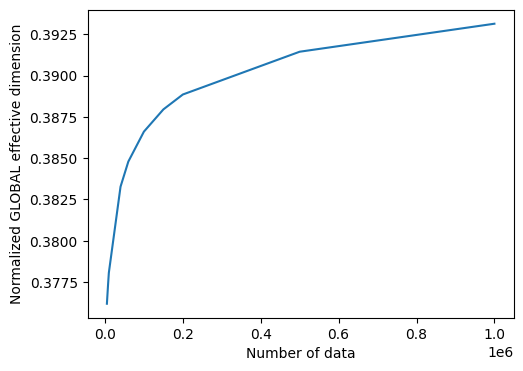

In [29]:
Quantumnet = simulator_train(feature_map, ansatz,'easy-2',output_dim=2)

name: Qiskit_easy_2_qnn_model
Transform Time elapsed:  4.171034097671509
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [09:49<00:00,  2.76s/it]

Train Epoch: 1/2 train loss 0.6778 Acc batch: 0.5580 learning_rate: 0.0010


Transform Time elapsed:  4.989197015762329
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [09:52<00:00,  2.77s/it]

Train Epoch: 2/2 train loss 0.6380 Acc batch: 0.6694 learning_rate: 0.0010
Time elapsed:  1191.5272889137268


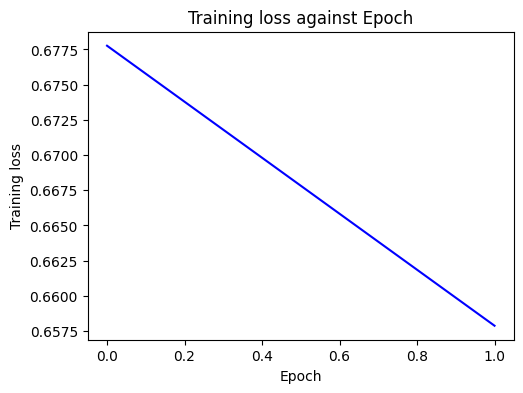

name: Qiskit_easy_2_qnn_model
Transform Time elapsed:  5.169398546218872
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:43<00:00,  3.01s/it]

Train Epoch: 1/18 train loss 0.5964 Acc batch: 0.7339 learning_rate: 0.0003


Transform Time elapsed:  4.979889869689941
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:38<00:00,  2.98s/it]

Train Epoch: 2/18 train loss 0.5991 Acc batch: 0.7157 learning_rate: 0.0003


Transform Time elapsed:  5.389120578765869
3 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:43<00:00,  3.01s/it]

Train Epoch: 3/18 train loss 0.5333 Acc batch: 0.8113 learning_rate: 0.0001


Transform Time elapsed:  5.369847059249878
4 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:39<00:00,  2.99s/it]

Train Epoch: 4/18 train loss 0.5216 Acc batch: 0.8253 learning_rate: 0.0001


Transform Time elapsed:  5.10561728477478
5 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:37<00:00,  2.98s/it]

Train Epoch: 5/18 train loss 0.5093 Acc batch: 0.8365 learning_rate: 0.0000


Transform Time elapsed:  5.063198804855347
6 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:39<00:00,  2.99s/it]

Train Epoch: 6/18 train loss 0.5001 Acc batch: 0.8488 learning_rate: 0.0000


Transform Time elapsed:  5.149282455444336
7 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:40<00:00,  2.99s/it]

Train Epoch: 7/18 train loss 0.4819 Acc batch: 0.8623 learning_rate: 0.0000


Transform Time elapsed:  5.113774299621582
8 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:39<00:00,  2.99s/it]

Train Epoch: 8/18 train loss 0.4806 Acc batch: 0.8658 learning_rate: 0.0000


Transform Time elapsed:  5.015721082687378
9 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:44<00:00,  3.01s/it]

Train Epoch: 9/18 train loss 0.4804 Acc batch: 0.8693 learning_rate: 0.0000


Transform Time elapsed:  5.119203329086304
10 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:42<00:00,  3.00s/it]

Train Epoch: 10/18 train loss 0.4770 Acc batch: 0.8728 learning_rate: 0.0000


Transform Time elapsed:  5.150094509124756
11 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:43<00:00,  3.01s/it]

Train Epoch: 11/18 train loss 0.4797 Acc batch: 0.8646 learning_rate: 0.0000


Transform Time elapsed:  5.342268705368042
12 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:39<00:00,  2.99s/it]

Train Epoch: 12/18 train loss 0.4750 Acc batch: 0.8757 learning_rate: 0.0000


Transform Time elapsed:  5.070875406265259
13 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:41<00:00,  3.00s/it]

Train Epoch: 13/18 train loss 0.4764 Acc batch: 0.8740 learning_rate: 0.0000


Transform Time elapsed:  5.174513101577759
14 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:43<00:00,  3.01s/it]

Train Epoch: 14/18 train loss 0.4798 Acc batch: 0.8693 learning_rate: 0.0000


Transform Time elapsed:  5.11414909362793
15 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:42<00:00,  3.00s/it]

Train Epoch: 15/18 train loss 0.4708 Acc batch: 0.8804 learning_rate: 0.0000


Transform Time elapsed:  5.160380840301514
16 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:42<00:00,  3.00s/it]

Train Epoch: 16/18 train loss 0.4840 Acc batch: 0.8587 learning_rate: 0.0000


Transform Time elapsed:  5.076307773590088
17 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:44<00:00,  3.01s/it]

Train Epoch: 17/18 train loss 0.4733 Acc batch: 0.8751 learning_rate: 0.0000


Transform Time elapsed:  5.128450155258179
18 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:43<00:00,  3.01s/it]

Train Epoch: 18/18 train loss 0.4761 Acc batch: 0.8728 learning_rate: 0.0000
Time elapsed:  11644.103657722473


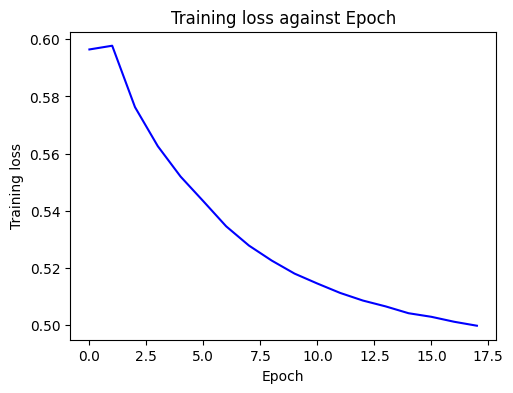

100%|████████████████████████████████████████████████████████████████████████████████| 730/730 [01:04<00:00, 11.35it/s]

              precision    recall  f1-score   support

           0     0.8892    0.8227    0.8547       361
           1     0.8384    0.8997    0.8680       369

    accuracy                         0.8616       730
   macro avg     0.8638    0.8612    0.8613       730
weighted avg     0.8635    0.8616    0.8614       730



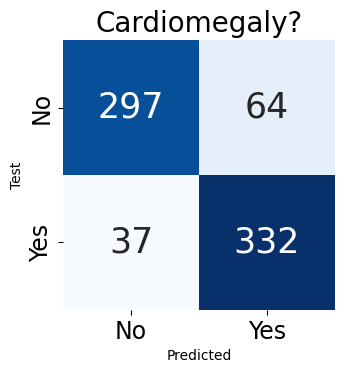

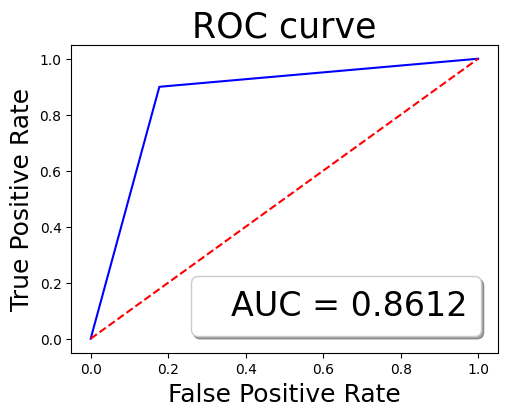

(3, 224, 224)


100%|██████████████████████████████████████████████████████████████████████████████| 1706/1706 [02:39<00:00, 10.67it/s]


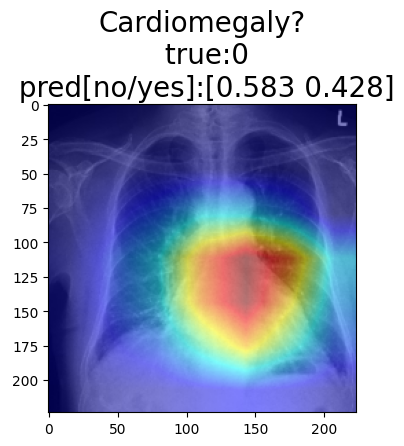

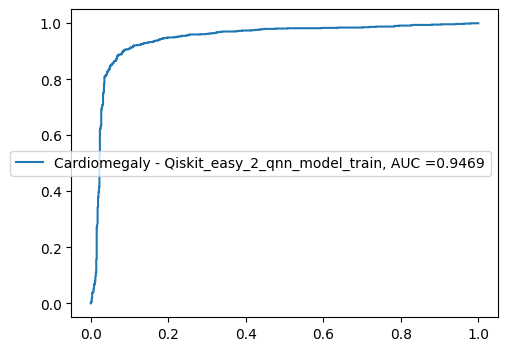

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       856
           1       0.91      0.90      0.91       850

    accuracy                           0.91      1706
   macro avg       0.91      0.91      0.91      1706
weighted avg       0.91      0.91      0.91      1706



100%|████████████████████████████████████████████████████████████████████████████████| 730/730 [01:08<00:00, 10.63it/s]


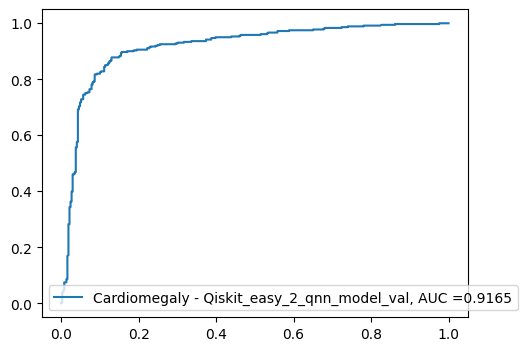

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       369
           1       0.89      0.82      0.85       361

    accuracy                           0.86       730
   macro avg       0.86      0.86      0.86       730
weighted avg       0.86      0.86      0.86       730



In [30]:
Qiskit_easy_2_qnn_model = torchvision.models.densenet121(weights= 'DEFAULT')
for param in Qiskit_easy_2_qnn_model.parameters():
    param.requires_grad = False
Qiskit_easy_2_qnn_model.classifier = Quantumnet(Qiskit_easy_2_qnn_model.classifier.in_features)
Qiskit_easy_2_qnn_model = train_func(Qiskit_easy_2_qnn_model, init_epochs, train_epochs)
for i in ['train','val']:
    exec(f"Qiskit_easy_2_qnn_model_{i}=make_csv(Qiskit_easy_2_qnn_model,'{i}')")

#### 4 Dim

tensor([0.3478, 0.2163, 0.1783, 0.2576], grad_fn=<_TorchNNFunctionBackward>)
Data size: 5000, global effective dimension: 17.0949
Number of weights: 24, normalized effective dimension: 0.7123
Effective dimension: [17.09487015 17.30959315 17.41102108 17.9927142  18.1411092  18.31300422
 18.43795941 18.52080861 18.75571317 18.90792654]
Number of weights: 24


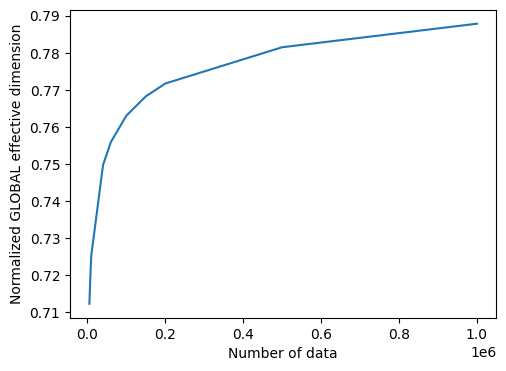

In [31]:
Quantumnet = simulator_train(feature_map, ansatz,'easy-4',output_dim=4)

name: Qiskit_easy_4_qnn_model
Transform Time elapsed:  4.942148447036743
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [09:47<00:00,  2.75s/it]

Train Epoch: 1/2 train loss 0.7250 Acc batch: 0.5018 learning_rate: 0.0010


Transform Time elapsed:  5.033770322799683
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [09:51<00:00,  2.77s/it]

Train Epoch: 2/2 train loss 0.6964 Acc batch: 0.5018 learning_rate: 0.0010
Time elapsed:  1189.5355398654938


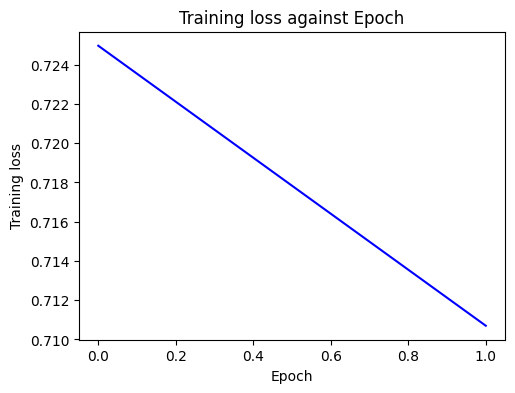

name: Qiskit_easy_4_qnn_model
Transform Time elapsed:  4.988124370574951
1 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:47<00:00,  3.03s/it]

Train Epoch: 1/18 train loss 0.6652 Acc batch: 0.5615 learning_rate: 0.0003


Transform Time elapsed:  5.138097286224365
2 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:51<00:00,  3.04s/it]

Train Epoch: 2/18 train loss 0.6593 Acc batch: 0.6741 learning_rate: 0.0003


Transform Time elapsed:  5.066467046737671
3 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:50<00:00,  3.04s/it]

Train Epoch: 3/18 train loss 0.6451 Acc batch: 0.7116 learning_rate: 0.0001


Transform Time elapsed:  5.064545154571533
4 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:50<00:00,  3.04s/it]

Train Epoch: 4/18 train loss 0.6310 Acc batch: 0.7427 learning_rate: 0.0001


Transform Time elapsed:  5.098059177398682
5 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:46<00:00,  3.02s/it]

Train Epoch: 5/18 train loss 0.6037 Acc batch: 0.8113 learning_rate: 0.0000


Transform Time elapsed:  5.340281963348389
6 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:52<00:00,  3.05s/it]

Train Epoch: 6/18 train loss 0.5962 Acc batch: 0.8253 learning_rate: 0.0000


Transform Time elapsed:  5.198030471801758
7 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:57<00:00,  3.07s/it]

Train Epoch: 7/18 train loss 0.5947 Acc batch: 0.8253 learning_rate: 0.0000


Transform Time elapsed:  5.212229251861572
8 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:55<00:00,  3.06s/it]

Train Epoch: 8/18 train loss 0.5871 Acc batch: 0.8453 learning_rate: 0.0000


Transform Time elapsed:  5.217546701431274
9 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:50<00:00,  3.04s/it]

Train Epoch: 9/18 train loss 0.5889 Acc batch: 0.8406 learning_rate: 0.0000


Transform Time elapsed:  5.111608505249023
10 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:45<00:00,  3.02s/it]

Train Epoch: 10/18 train loss 0.5856 Acc batch: 0.8482 learning_rate: 0.0000


Transform Time elapsed:  5.136101007461548
11 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:49<00:00,  3.04s/it]

Train Epoch: 11/18 train loss 0.5856 Acc batch: 0.8476 learning_rate: 0.0000


Transform Time elapsed:  5.157522201538086
12 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:46<00:00,  3.02s/it]

Train Epoch: 12/18 train loss 0.5852 Acc batch: 0.8476 learning_rate: 0.0000


Transform Time elapsed:  5.1005165576934814
13 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:46<00:00,  3.02s/it]

Train Epoch: 13/18 train loss 0.5872 Acc batch: 0.8423 learning_rate: 0.0000


Transform Time elapsed:  5.0373215675354
14 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:50<00:00,  3.04s/it]

Train Epoch: 14/18 train loss 0.5824 Acc batch: 0.8558 learning_rate: 0.0000


Transform Time elapsed:  4.985658168792725
15 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:57<00:00,  3.07s/it]

Train Epoch: 15/18 train loss 0.5857 Acc batch: 0.8476 learning_rate: 0.0000


Transform Time elapsed:  5.060117244720459
16 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:52<00:00,  3.05s/it]

Train Epoch: 16/18 train loss 0.5886 Acc batch: 0.8359 learning_rate: 0.0000


Transform Time elapsed:  5.948427200317383
17 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:55<00:00,  3.06s/it]

Train Epoch: 17/18 train loss 0.5841 Acc batch: 0.8511 learning_rate: 0.0000


Transform Time elapsed:  5.213897228240967
18 Training started:


100%|████████████████████████████████████████████████████████████████████████████████| 214/214 [10:48<00:00,  3.03s/it]

Train Epoch: 18/18 train loss 0.5859 Acc batch: 0.8423 learning_rate: 0.0000
Time elapsed:  11807.212325572968


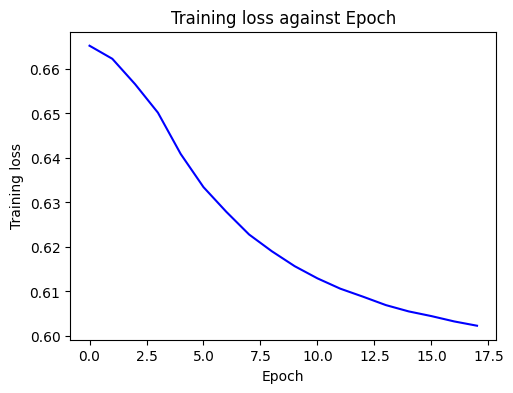

100%|████████████████████████████████████████████████████████████████████████████████| 730/730 [01:03<00:00, 11.54it/s]


              precision    recall  f1-score   support

           0     0.9212    0.7452    0.8239       361
           1     0.7900    0.9377    0.8575       369

    accuracy                         0.8425       730
   macro avg     0.8556    0.8414    0.8407       730
weighted avg     0.8549    0.8425    0.8409       730



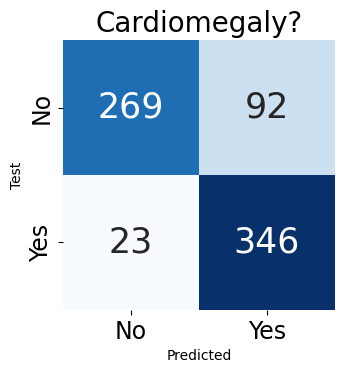

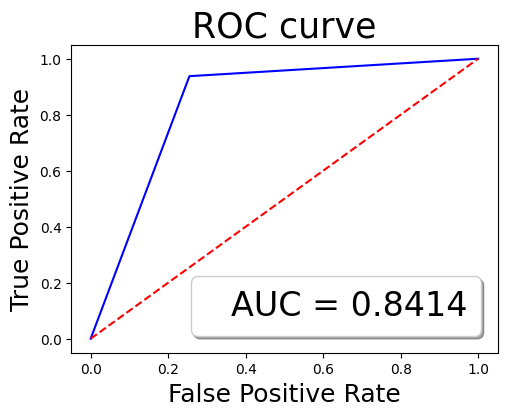

(3, 224, 224)


100%|██████████████████████████████████████████████████████████████████████████████| 1706/1706 [02:42<00:00, 10.49it/s]


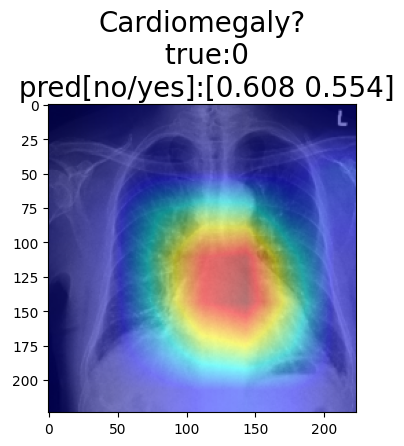

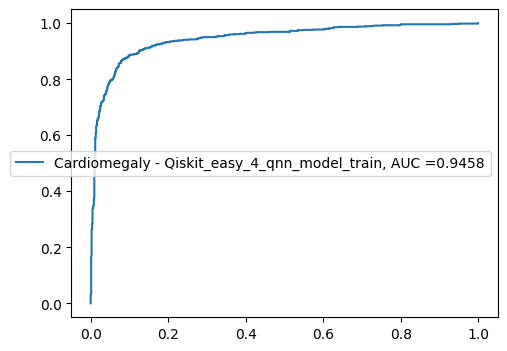

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       856
           1       0.93      0.82      0.87       850

    accuracy                           0.88      1706
   macro avg       0.89      0.88      0.88      1706
weighted avg       0.88      0.88      0.88      1706



100%|████████████████████████████████████████████████████████████████████████████████| 730/730 [01:10<00:00, 10.32it/s]


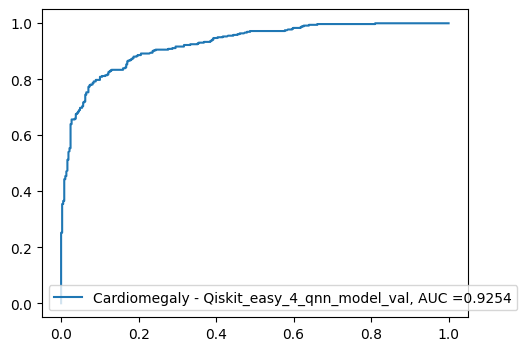

              precision    recall  f1-score   support

           0       0.79      0.94      0.86       369
           1       0.92      0.75      0.82       361

    accuracy                           0.84       730
   macro avg       0.86      0.84      0.84       730
weighted avg       0.85      0.84      0.84       730



In [32]:
Qiskit_easy_4_qnn_model = torchvision.models.densenet121(weights= 'DEFAULT')
for param in Qiskit_easy_4_qnn_model.parameters():
    param.requires_grad = False
Qiskit_easy_4_qnn_model.classifier = Quantumnet(Qiskit_easy_4_qnn_model.classifier.in_features)
Qiskit_easy_4_qnn_model = train_func(Qiskit_easy_4_qnn_model, init_epochs, train_epochs)
for i in ['train','val']:
    exec(f"Qiskit_easy_4_qnn_model_{i}=make_csv(Qiskit_easy_4_qnn_model,'{i}')")